# Cats vs Dog Replication, Version 1

This notebook implements the method introduced in the first 3 lessons in part 1 of the FastAI deep learning course to build a pretty good image classification model for cats and dogs classification using the `fastai` library. The model scored a log loss of 0.05664, which is good for around top 8% at the time of writing.

Dataset is from an old Kaggle competition called Dogs vs. Cats Redux: Kernels Edition. It can be downloaded by executing `kaggle competitions download -c dogs-vs-cats-redux-kernels-edition` using the official Kaggle CLI.

How to organize training data so that all cat and dog pictures are in their individual folders within the `train` folder.

## To Do:
1. Finish 8th step and train model on full training dataset
2. Submit the quick model without using any of the advanced techniques to see how it compares with the better model

In [2]:
import sys; sys.path.append('../fastai')

In [3]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [53]:
PATH = "/home/pspenano/Dropbox/data_science/fastai_deeplearning/pt1/data/dogs-vs-cats-redux-kernels-edition/"

# model parameters
sz = 224
arch = resnet34

In [10]:
print(torch.cuda.is_available())
print(torch.backends.cudnn.enabled)

True
True


In [ ]:
os.listdir(PATH+'train/dog')

Cell directly below prepares the data in the following way:

Input: train.zip (downloaded from Kaggle)

Output: folders with directory structure

```
    - train
        - cat
        - dog
    - valid
        - cat
        - dog
```

`valid` contains 10% of the data from the original `train` folder.

In [96]:
import os, random, shutil

# delete training folder if it already exist and unzip orig. train data
!cd {PATH};
!rm -rf valid/;
!rm -rf train/;
!unzip -q train.zip;

print("Total number of images in training data:", len(os.listdir('train')))

# create subdirectory that will contain classes
!mkdir "{PATH}train/dog";
!mkdir "{PATH}train/cat";

# move images to class folder
!mv {PATH}train/dog*jpg "{PATH}train/dog/";
!mv {PATH}train/cat*jpg "{PATH}train/cat/";

cat_train = PATH+'train/cat'
dog_train = PATH+'train/dog'

# get number of examples for each class
num_cats_img = len(os.listdir(cat_train))
print("Number cats images:", num_cats_img)

num_dogs_img = len(os.listdir(dog_train))
print("Number dogs images:", num_dogs_img)

# get 10% sample size for validation set
valid_num = int(0.10 * num_cats_img)

# get a random sample for cats and dogs
valid_set_cat = random.sample(os.listdir(cat_train), valid_num)
valid_set_dog = random.sample(os.listdir(dog_train), valid_num)

# create validation folder structure
mkdir_valid(PATH+"valid")
mkdir_valid(PATH+"valid/cat")
mkdir_valid(PATH+"valid/dog")


# move randomly selected images to validation folder
cat_valid = PATH+'valid/cat'
dog_valid = PATH+'valid/dog'

for df,cf in zip(valid_set_dog, valid_set_cat):
    shutil.move(dog_train+'/'+df, dog_valid)
    shutil.move(cat_train+'/'+cf, cat_valid)

print(os.listdir(PATH+"valid/dog")[0:10])
print("Count of validation set for dogs class:", len(os.listdir(dog_valid)))
print("Count of validation set for cats class:", len(os.listdir(cat_valid)))


Total number of images in training data: 25000
Number cats images: 12500
Number dogs images: 12500
['dog.953.jpg', 'dog.5279.jpg', 'dog.2387.jpg', 'dog.6469.jpg', 'dog.1400.jpg', 'dog.732.jpg', 'dog.11706.jpg', 'dog.9682.jpg', 'dog.6077.jpg', 'dog.11954.jpg']
Count of validation set for dogs class: 1250
Count of validation set for cats class: 1250


### First quick model
Here is a very basic convolutional neural network model trained for 3 epochs without any application of the other techniques to improve performance.

#### To Do:
* Submit the output of this model to Kaggle as a baseline

In [98]:
tfms = tfms_from_model(arch,sz)
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 3)
learn.save('224_quickmodel')


100%|██████████| 40/40 [00:05<00:00,  7.29it/s]


HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      0.049149   0.023227   0.992188  
    1      0.042476   0.024563   0.991406  
    2      0.037937   0.022626   0.991797  



### End-to-End Workflow for Training a World Class Model

#### 1. Enable data augmentation and precompute=True
Depending on the images we are working with, set `aug_tfms` to either transforms_side_on or transform_top_down (for satellite images). For ImageNet like images, we use transforms_side_on.

In [110]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms)

#### 2. Find learning rate to be used to train dense layer of model

First, find a learning rate using the learning rate finder method. To do this, we must define a new, untrained, mode. We are finding the learning rate only from the unfrozen dense layer (the last layer in the convolutional neural net) that we want to customize for our image data. The Python methods used here are:
    * lr_find()
    * plot_lr() (from sched)
    * plot() (also from sched 

In [111]:
find_lr_learner = ConvLearner.pretrained(arch, data, precompute=True)
lrf = find_lr_learner.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 75%|███████▌  | 264/352 [00:04<00:01, 54.66it/s, loss=0.405]


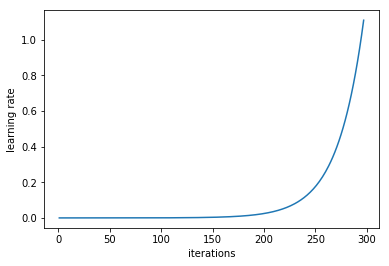

In [112]:
find_lr_learner.sched.plot_lr()

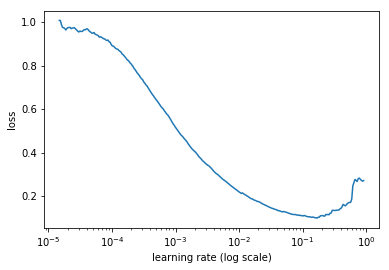

In [113]:
find_lr_learner.sched.plot()

Based on the analysis of the loss function against various learning rates, the optimal learning rate is the value just before the learning where loss is at the minimum. We can pick 1e-2.

#### 3. Train last layer from precomputed activations for 1 to 2 epochs
We will use the learning rate we found above to train the last layer of the model. We initialize a new model by using the ConvLearner class (and bind it to the learn variable) and pass the architecture and data we have defined and initialized for it. We will not use the model we used to find our learning rate.

In [114]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [115]:
learn.fit(1e-2, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      0.04071    0.026976   0.991016  
    1      0.043275   0.025328   0.989844  



[0.025327588, 0.98984375]

#### 4. Train last layer with data augmentation with cycle_len=1 

Here we train just the last layer. The reason we do this first before training the entire network in step 5 is because the final layer only have random values for paramters. We wouldn't want to train the entire network first while having an untrained final layer.

__Questions !!!__

1. What is cycle_len=1? Why do we use it?
2. Why not do this step at step 3? why do we first do an initial training with non-augmented data?
3. Why not just jump straight to unfreezing the entire model and training it using differential learning rates (i.e. jump straight to step 5)?

Note that you don't need to run this again because you can load the model that you trained earlier. Use `learn.load(MODELNAME)`.

In [116]:
learn.precompute = False
learn.fit(1e-2, 3, cycle_len=1)

# Save model so we don't have to train it from scratch next time
learn.save('224_lastlayer_catsVDog_replication_V1')
learn.load('224_lastlayer_catsVDog_replication_V1')

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      0.049117   0.022505   0.992578  
    1      0.03515    0.02173    0.991406  
    2      0.032252   0.022384   0.990234  



#### 5. Unfreeze all layers
Unfreeze early, middle and later layers. We are at this point going to train all the layers starting from their pretrained parameter values.

In [117]:
learn.unfreeze()

#### 6. Set earlier layers to 3x-10x lower learning rate than next higher layer
In training all the layers, we only want to only want maximum customization of the parameters of the later layers. For the early layers, these have been trained to detect very general attributes that is also applicable to our dataset. Thus, we don't want to train these early layers too much and so we set the learning rate for these early layer to be 10 times smaller than the last layer.

In [118]:
lr=np.array([1e-4,1e-3,1e-2])
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)
learn.save('224_trainedAll_catsVDog_replication_V1')
learn.load('224_trainedAll_catsVDog_replication_V1')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      0.050769   0.024503   0.991406  
    1      0.03659    0.018283   0.993359  
    2      0.031703   0.020365   0.992969  
    3      0.028645   0.017113   0.994922  
    4      0.025561   0.016879   0.994922  
    5      0.0215     0.017832   0.99375   
    6      0.020041   0.016173   0.994141  



#### 7. Use learning rate finder again
Before training the full network again, we need to find a new learning rate. The current learning rate may no longer be optimal given that it was found before we trained the entire unfrozen network. It may no longer be the optimal learning rate for the current model that has been trainined using differential learning rates.

#### 8. Train full network with cycle_mult=2 until overfitting


In [122]:
# unzip training data again to get full dataset
!rm -rf train_full

!unzip -q train.zip -d train_full;

!mkdir "{PATH}train_full/train/dog";
!mkdir "{PATH}train_full/train/cat";

# move images to class folder
!mv {PATH}train_full/train/dog*jpg "{PATH}train_full/train/dog/";
!mv {PATH}train_full/train/cat*jpg "{PATH}train_full/train/cat/";

PATH_FULL = "/home/pspenano/Dropbox/data_science/fastai_deeplearning/pt1/data/dogs-vs-cats-redux-kernels-edition/train_full"

### Load Previously Trained Model
To load model starting from step 6 (and avoid having to retrain the entire network), run the following code

In [127]:
os.listdir(PATH)

['test',
 'models',
 'train',
 'train.zip',
 'sample_submission.csv',
 'test.zip',
 'tmp',
 'train_full',
 'valid']

In [131]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, test_name='test')

# Initialize learner with precompute=False to match model that
# we have trained using differential learning rates (in step 6)
learn = ConvLearner.pretrained(arch, data, precompute=False)
learn.load('224_trainedAll_catsVDog_replication_V1')

### Create Kaggle Submission

To make submission after creating submission file, execute 

`kaggle competitions submit -c dogs-vs-cats-redux-kernels-edition -f submission_2018-03-10.csv -m "first submission: resnet34 fastai lesson 2 and 3 techniques"`

Evaluate model using test set and get predicted probabilities for each image.

In [ ]:
# get log of prediction using test-time augmentation
log_preds,y = learn.TTA(is_test=True)

# convert prediction to probability
probs = np.mean(np.exp(log_preds),0)

# get prediction (if prob > 0.5, then dog)
preds = np.argmax(probs, axis=1)

# get second column (which corresponds to probability that it is a dog)
probs = probs[:,1] 

We retrieve the labels of the images in the test set using `data.test_ds.fnames` and create a dataframe containing the predicted probability that each image in the test set is a dog.

In [158]:
ds = pd.DataFrame(probs)

# set column name of predictive probabilities
ds.columns = ['label']

# remove folder name and img suffix
ids = [x[5:-4] for x in data.test_ds.fnames]

# insert in first column with name id
ds.insert(0, 'id', ids)

ds.head()

,id,label
0,5880,0.999985
1,1218,0.000106
2,641,0.999965
3,12255,0.016852
4,10844,0.999989


In [166]:
import datetime

PATH_SUBMISSION = '/home/pspenano/Dropbox/data_science/fastai_deeplearning/pt1/fastai_deeplearning_v2_pt1/kaggle_submissions/cats_vs_dogs_redux/'
ds.to_csv(PATH_SUBMISSION + 'submission_{}.csv'.format(datetime.date.today()), index=False)